In [ ]:
# @title ###### Licensed to the Apache Software Foundation (ASF), Version 2.0 (the "License")

# Licensed to the Apache Software Foundation (ASF) under one
# or more contributor license agreements. See the NOTICE file
# distributed with this work for additional information
# regarding copyright ownership. The ASF licenses this file
# to you under the Apache License, Version 2.0 (the
# "License"); you may not use this file except in compliance
# with the License. You may obtain a copy of the License at
#
#   http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing,
# software distributed under the License is distributed on an
# "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY
# KIND, either express or implied. See the License for the
# specific language governing permissions and limitations
# under the License

# Remote inference in Apache Beam

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/apache/beam/blob/master/examples/notebooks/beam-ml/custom_remote_inference.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/colab_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/apache/beam/blob/master/examples/notebooks/beam-ml/custom_remote_inference.ipynb"><img src="https://raw.githubusercontent.com/google/or-tools/main/tools/github_32px.png" />View source on GitHub</a>
  </td>
</table>


This example demonstrates how to implement a custom inference call in Apache Beam by using the Google Cloud Vision API.

The prefered way to run inference in Apache Beam is by using the [RunInference API](https://beam.apache.org/documentation/sdks/python-machine-learning/).
The RunInference API enables you to run models as part of your pipeline in a way that is optimized for machine learning inference.
To reduce the number of steps in your pipeline, RunInference supports features like batching. For more infomation about the RunInference API, review the [RunInference API](https://beam.apache.org/releases/pydoc/current/apache_beam.ml.inference.html#apache_beam.ml.inference.RunInference).

This notebook creates a custom model handler to make remote inference calls by using the Cloud Vision API. To make remote inference calls to Vertex AI, use the [Vertex AI model handler JSON](https://github.com/apache/beam/blob/master/sdks/python/apache_beam/ml/inference/vertex_ai_inference.py).

**Note:** All images are licensed CC-BY. Creators are listed in the [LICENSE.txt](https://storage.googleapis.com/apache-beam-samples/image_captioning/LICENSE.txt) file.

## Run the Cloud Vision API

You can use the Cloud Vision API to retrieve labels that describe an image.
For example, the following image shows a cat with possible labels.

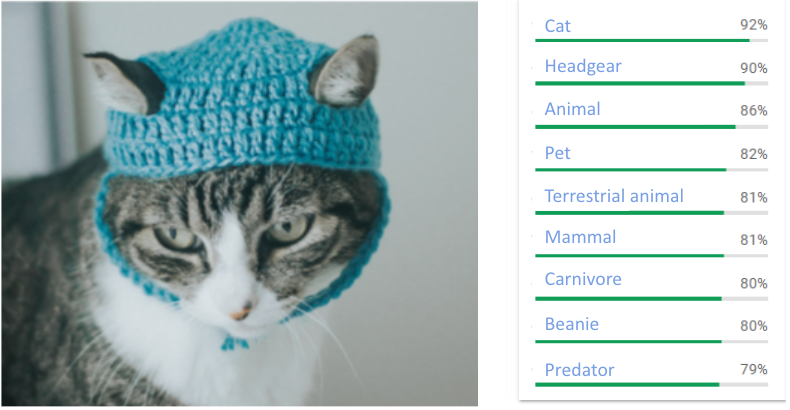

To run the Google Cloud Vision API on a large set of images, Apache Beam is the ideal tool to handle the workflow.
This example demonstates how to retrieve image labels with this API on a small set of images.

The example follows these steps:
* Read the images.
* Send the images to an external API to run inference by using the `RunInference PTransform`.
* Postprocess the results of your API.

**Caution:** Be aware of API quotas and the heavy load you might incur on your external API. Verify that your pipeline and API are configured correctly for your use case.

To optimize the calls to the external API, limit the parallel calls to the external remote API by [configuring pipeline options](https://beam.apache.org/documentation/programming-guide/#configuring-pipeline-options).
In Apache Beam, each runner provides options to handle the parallelism. The following list includes two examples:
* With the [Direct Runner](https://beam.apache.org/documentation/runners/direct/), use the `direct_num_workers` pipeline option.
* With the [Google Cloud Dataflow Runner](https://beam.apache.org/documentation/runners/dataflow/), use the `max_num_workers` pipeline option.

For information about other runners, see the [Beam capability matrix](https://beam.apache.org/documentation/runners/capability-matrix/)

## Before you begin

Download and install the dependencies.

In [ ]:
!pip install --upgrade pip
!pip install protobuf==3.19.4
!pip install apache-beam[interactive,gcp]>=2.40.0
!pip install google-cloud-vision==3.1.1
!pip install requests

# To use the newly installed version, restart the runtime.
exit()

To use the Cloud Vision API, authenticate with Google Cloud.

In [ ]:
# Follow the steps to configure your Google Cloup setup.
!gcloud init

In [ ]:
!gcloud auth application-default login

## Run remote inference on Cloud Vision API

This section shows how to run remote inference on the Cloud Vision API.

Download and install Apache Beam and the required modules.

In [ ]:
from typing import List
import io
import os
import requests

from google.cloud import vision
from google.cloud.vision_v1.types import Feature
import apache_beam as beam
from apache_beam.ml.inference.base import ModelHandler
from apache_beam.ml.inference.base import RunInference


This example uses images from the [MSCoco dataset](https://cocodataset.org/#explore) as a list of image URLs.
This data is used as the pipeline input.

In [ ]:
image_urls = [
    "http://farm3.staticflickr.com/2824/10213933686_6936eb402b_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
    "http://farm8.staticflickr.com/7003/6528937031_10e1ce0960_z.jpg",
    "http://farm6.staticflickr.com/5207/5304302785_7b5f763190_z.jpg",
    "http://farm6.staticflickr.com/5207/5304302785_7b5f763190_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
    "http://farm8.staticflickr.com/7026/6388965173_92664a0d78_z.jpg",
]

def read_image(image_url):
  """Read image from url and return image_url, image bytes"""
  response = requests.get(image_url)
  image_bytes = io.BytesIO(response.content).read()
  return image_url, image_bytes

### Create a custom model handler

In order to implement remote inference, create a custom model handler. Use the `run_inference` method to implement the model call and to return its results.

When you run remote inference, prepare to encounter, identify, and handle failure as gracefully as possible. We recommend using the following techniques:

* **Exponential backoff:** Retry failed remote calls with exponentially growing pauses between retries. Using exponential backoff ensures that failures don't lead to an overwhelming number of retries in quick succession.

* **Dead-letter queues:** Route failed inferences to a separate `PCollection` without failing the whole transform. Continue execution without failing the job (batch jobs' default behavior) or retrying indefinitely (streaming jobs' default behavior).
You can then run custom pipeline logic on the dead-letter (unprocessed messages) queue to log the failure, send an alert, and push the failed message to temporary storage so that it can eventually be reprocessed.

In [ ]:
class CloudVisionModelHandler(ModelHandler):
  """DoFn that accepts a batch of images as bytearray
  and sends that batch to the Cloud Vision API for remote inference"""
  def load_model(self):
    """Initiate the Google Vision API client."""
    client = vision.ImageAnnotatorClient()
    return client

  def run_inference(self, batch, model, inference):
    feature = Feature()
    feature.type_ = Feature.Type.LABEL_DETECTION

    # The list of image_urls
    image_urls = [image_url for (image_url, image_bytes) in batch]

    # Create a batch request for all images in the batch.
    images = [vision.Image(content=image_bytes) for (image_url, image_bytes) in batch]
    image_requests = [vision.AnnotateImageRequest(image=image, features=[feature]) for image in images]
    batch_image_request = vision.BatchAnnotateImagesRequest(requests=image_requests)

    # Send the batch request to the remote endpoint.
    responses = model.batch_annotate_images(request=batch_image_request).responses

    return list(zip(image_urls, responses))


### Manage batching

When you run inference with your model, either in Apache Beam or in an external API, batch your input to increase the efficiency of the model execution.
The `RunInference PTransform` automatically manages batching by using the `BatchElements` transform to dynamically group elements together into batches based on the throughput of the pipeline.

If you are designing your own API endpoint, make sure that it can handle batches.



### Create the pipeline

This section demonstrates how to chain the pipeline steps together to complete the following tasks:

* Read data.

* Transform the data to fit the model input.

* Run inference with a custom Cloud Vision model handler.

* Process and display the results.

In [ ]:
with beam.Pipeline() as pipeline:
  _ = (pipeline | "Create inputs" >> beam.Create(image_urls)
                | "Read images" >> beam.Map(read_image)
                | "Inference" >> RunInference(model_handler=CloudVisionModelHandler())
                | "Print image_url and annotation" >> beam.Map(print)
  )

('http://farm3.staticflickr.com/2824/10213933686_6936eb402b_z.jpg', label_annotations {
  mid: "/m/083wq"
  description: "Wheel"
  score: 0.977976143
  topicality: 0.977976143
}
label_annotations {
  mid: "/m/0h9mv"
  description: "Tire"
  score: 0.977934957
  topicality: 0.977934957
}
label_annotations {
  mid: "/m/043g5f"
  description: "Fuel tank"
  score: 0.958490431
  topicality: 0.958490431
}
label_annotations {
  mid: "/m/05s2s"
  description: "Plant"
  score: 0.95674181
  topicality: 0.95674181
}
label_annotations {
  mid: "/m/0h8lk_j"
  description: "Automotive fuel system"
  score: 0.941456497
  topicality: 0.941456497
}
label_annotations {
  mid: "/m/07yv9"
  description: "Vehicle"
  score: 0.936428607
  topicality: 0.936428607
}
label_annotations {
  mid: "/m/02qwkrn"
  description: "Vehicle brake"
  score: 0.905624092
  topicality: 0.905624092
}
label_annotations {
  mid: "/m/0h8pb3l"
  description: "Automotive tire"
  score: 0.897686064
  topicality: 0.897686064
}
label_a

## Monitor the pipeline

Because monitoring can provide insight into the status and health of the application, consider monitoring and measuring pipeline performance.
For information about the available tracking metrics, see [RunInference Metrics](https://beam.apache.org/documentation/ml/runinference-metrics/).